In [ ]:
!pip install transformers
!pip install tensorflow

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define paths
dataset_path = '/content/drive/My Drive/FruitIQ'

# ImageDataGenerator for loading and preprocessing the dataset with augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2  # 20% for validation
)

train_generator = train_datagen.flow_from_directory(
    dataset_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

validation_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

validation_generator = validation_datagen.flow_from_directory(
    dataset_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)

Found 1280 images belonging to 16 classes.
Found 320 images belonging to 16 classes.


In [2]:
from transformers import TFViTModel, ViTConfig
from tensorflow.keras import layers, models, optimizers, callbacks

# Load pre-trained ViT model from Hugging Face
config = ViTConfig.from_pretrained('google/vit-base-patch16-224-in21k')
vit_model = TFViTModel.from_pretrained('google/vit-base-patch16-224-in21k', config=config)

# Define the model architecture
input_layer = layers.Input(shape=(224, 224, 3))
permuted_input = layers.Permute((3, 1, 2))(input_layer)  # Permute the input dimensions
vit_output = vit_model(permuted_input)[0]  # Get the outputs from ViT

# Add additional layers
flatten = layers.Flatten()(vit_output)
dense1 = layers.Dense(256, activation='relu')(flatten)
dropout = layers.Dropout(0.5)(dense1)
output_layer = layers.Dense(16, activation='softmax')(dropout)

model = models.Model(inputs=input_layer, outputs=output_layer)

# Compile the model
model.compile(optimizer=optimizers.Adam(learning_rate=1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

All PyTorch model weights were used when initializing TFViTModel.

All the weights of TFViTModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFViTModel for predictions without further training.


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 permute (Permute)           (None, 3, 224, 224)          0         ['input_1[0][0]']             
                                                                                                  
 tf.compat.v1.transpose (TF  (None, 224, 224, 3)          0         ['permute[0][0]']             
 OpLambda)                                                                                        
                                                                                                  
 tf.compat.v1.shape (TFOpLa  (4,)                         0         ['permute[0][0]']         

In [1]:
# Define callbacks
checkpoint = callbacks.ModelCheckpoint('/content/drive/My Drive/best_model_weights.h5',
                                       monitor='val_accuracy',
                                       save_best_only=True,
                                       mode='max',
                                       save_weights_only=True)  # Save only the weights

early_stopping = callbacks.EarlyStopping(monitor='val_accuracy',
                                         patience=5,
                                         mode='max',
                                         restore_best_weights=True)

# Train the model
history = model.fit(
    train_generator,
    epochs=20,
    validation_data=validation_generator,
    callbacks=[checkpoint, early_stopping]
)

Epoch 1/20
40/40 [==============================] - 1619s 40s/step - loss: 0.4073 - accuracy: 0.8734 - val_loss: 0.0983 - val_accuracy: 0.9750
Epoch 2/20
40/40 [==============================] - 1538s 39s/step - loss: 0.0606 - accuracy: 0.9789 - val_loss: 0.0622 - val_accuracy: 0.9844
Epoch 3/20
40/40 [==============================] - 1538s 39s/step - loss: 0.0396 - accuracy: 0.9867 - val_loss: 0.1201 - val_accuracy: 0.9781
Epoch 4/20
18/40 [============>.................] - ETA: 11:06 - loss: 0.0158 - accuracy: 0.9948

In [30]:
import warnings
warnings.filterwarnings('ignore')

import cv2
import numpy as np
from PIL import Image
from transformers import TFViTModel, ViTConfig
from tensorflow.keras import layers, models, optimizers

# Load the trained model
def load_model():
    config = ViTConfig.from_pretrained('google/vit-base-patch16-224-in21k')
    vit_model = TFViTModel.from_pretrained('google/vit-base-patch16-224-in21k', config=config)

    input_layer = layers.Input(shape=(224, 224, 3))
    permuted_input = layers.Permute((3, 1, 2))(input_layer)  # Permute the input dimensions
    vit_output = vit_model(permuted_input)[0]  # Get the outputs from ViT

    flatten = layers.Flatten()(vit_output)
    dense1 = layers.Dense(256, activation='relu')(flatten)
    dropout = layers.Dropout(0.5)(dense1)
    output_layer = layers.Dense(16, activation='softmax')(dropout)

    model = models.Model(inputs=input_layer, outputs=output_layer)
    model.compile(optimizer=optimizers.Adam(learning_rate=1e-4),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

# Load the trained model
model = load_model()
model.load_weights('/content/drive/My Drive/best_model_weights.h5')  # Load the best weights

# Define class names
class_names = ['Apple_Healthy','Apple_Rotten','Banana_Healthy','Banana_Rotten','Grape_Healthy','Grape_Rotten','Guava_Healthy','Guava_Rotten','Mango_Healthy','Mango_Rotten','Orange_Healthy','Orange_Rotten','Pomogranate_Healthy','Pomogranate_Rotten','Strawberry_Healthy','Strawberry_Rotten']

# Function to preprocess the image
def preprocess_image(image):
    image = Image.fromarray(image).convert('RGB')  # Ensure image is in RGB format
    image = image.resize((224, 224))  # Resize image to match model's expected sizing
    image = np.array(image) / 255.0  # Normalize pixel values to [0, 1]
    image = np.expand_dims(image, axis=0)  # Add batch dimension
    return image

# Function to predict the class of an image
def predict_image_class(image):
    image = preprocess_image(image)
    predictions = model.predict(image)[0]
    predicted_class = np.argmax(predictions)
    return class_names[predicted_class], predictions[predicted_class]

# Function to process video and classify
def classify_video(video_path):
    cap = cv2.VideoCapture(video_path)
    frame_rate = int(cap.get(cv2.CAP_PROP_FPS))

    rotten_detected = False
    frame_count = 0

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        frame_count += 1
        if frame_count % frame_rate == 0:  # Process one frame per second
            predicted_class, confidence = predict_image_class(frame)
            print(f'Frame {frame_count}: Predicted class: {predicted_class}, Confidence: {confidence:.4f}')

            if 'Rotten' in predicted_class:
                rotten_detected = True
                break

    cap.release()

    if rotten_detected:
        print("The video contains rotten fruit.")
    else:
        print("All frames are fine. The fruit is healthy.")



All PyTorch model weights were used when initializing TFViTModel.

All the weights of TFViTModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFViTModel for predictions without further training.


In [31]:
video_path2 = '/content/drive/My Drive/a1.mp4'
classify_video(video_path2)
'''video_path2 = '/content/drive/My Drive/m2.mp4'
classify_video(video_path2)
video_path3 = '/content/drive/My Drive/m3.mp4'
classify_video(video_path3)'''

1/1 [==============================] - 5s 5s/step
Frame 29: Predicted class: Apple_Healthy, Confidence: 0.8265
1/1 [==============================] - 1s 701ms/step
Frame 58: Predicted class: Apple_Healthy, Confidence: 0.9431
1/1 [==============================] - 1s 720ms/step
Frame 87: Predicted class: Apple_Healthy, Confidence: 0.9493
1/1 [==============================] - 1s 722ms/step
Frame 116: Predicted class: Apple_Healthy, Confidence: 0.7725
All frames are fine. The fruit is healthy.


"video_path2 = '/content/drive/My Drive/m2.mp4'\nclassify_video(video_path2)\nvideo_path3 = '/content/drive/My Drive/m3.mp4'\nclassify_video(video_path3)"

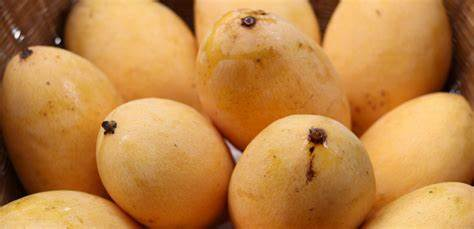

In [32]:
img = Image.open('/content/drive/MyDrive/Fresh.jpeg')
img

In [35]:
import numpy as np
from PIL import Image
import tensorflow as tf

# Function to preprocess the image
def preprocess_image(image_path):
    # Load the image
    image = Image.open(image_path)
    # Resize the image to the input size expected by the model (e.g., 224x224 for many models)
    image = image.resize((224, 224))
    # Convert the image to a NumPy array
    image_array = np.array(image)
    # Normalize the image array (values between 0 and 1)
    image_array = image_array / 255.0
    # Expand dimensions to match the expected input shape of the model (batch size, height, width, channels)
    image_array = np.expand_dims(image_array, axis=0)
    return image_array

# Function to predict the class of an image
def predict_image_class(image_path):
    # Preprocess the image
    image = preprocess_image(image_path)

    # Predict the class probabilities
    predictions = model.predict(image)[0]
    predicted_class = np.argmax(predictions)

    # Define your class names
    class_names = [
        'Apple_Healthy', 'Apple_Rotten', 'Banana_Healthy', 'Banana_Rotten',
        'Grape_Healthy', 'Grape_Rotten', 'Guava_Healthy', 'Guava_Rotten',
        'Mango_Healthy', 'Mango_Rotten', 'Orange_Healthy', 'Orange_Rotten',
        'Pomegranate_Healthy', 'Pomegranate_Rotten', 'Strawberry_Healthy',
        'Strawberry_Rotten'
    ]

    # Return the predicted class name and probability
    return class_names[predicted_class], predictions[predicted_class]

# Example usage:
image_path = '/content/drive/MyDrive/Fresh.jpeg'
predicted_class, confidence = predict_image_class(image_path)
print(f'Predicted class: {predicted_class}, Confidence: {confidence:.4f}')


1/1 [==============================] - 1s 740ms/step
Predicted class: Mango_Healthy, Confidence: 0.4539


# **MODEL 2 - Variety**

In [39]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define paths
dataset_path1 = '/content/drive/My Drive/Classification_dataset'

# ImageDataGenerator for loading and preprocessing the dataset with augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2  # 20% for validation
)

train_generator = train_datagen.flow_from_directory(
    dataset_path1,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

validation_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

validation_generator = validation_datagen.flow_from_directory(
    dataset_path1,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)

Found 1280 images belonging to 8 classes.
Found 320 images belonging to 8 classes.


In [3]:
from transformers import TFViTModel, ViTConfig
from tensorflow.keras import layers, models, optimizers, callbacks

# Load pre-trained ViT model from Hugging Face
config1 = ViTConfig.from_pretrained('google/vit-base-patch16-224-in21k')
vit_model1 = TFViTModel.from_pretrained('google/vit-base-patch16-224-in21k', config=config1)

# Define the model architecture
input_layer1 = layers.Input(shape=(224, 224, 3))
permuted_input1 = layers.Permute((3, 1, 2))(input_layer1)  # Permute the input dimensions
vit_output1 = vit_model1(permuted_input1)[0]  # Get the outputs from ViT

# Add additional layers
flatten1 = layers.Flatten()(vit_output1)
dense1 = layers.Dense(256, activation='relu')(flatten1)
dropout1 = layers.Dropout(0.5)(dense1)
output_layer1 = layers.Dense(8, activation='softmax')(dropout1)

model = models.Model(inputs=input_layer1, outputs=output_layer1)

# Compile the model
model.compile(optimizer=optimizers.Adam(learning_rate=1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

All PyTorch model weights were used when initializing TFViTModel.

All the weights of TFViTModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFViTModel for predictions without further training.


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 permute_1 (Permute)         (None, 3, 224, 224)          0         ['input_2[0][0]']             
                                                                                                  
 tf.compat.v1.transpose_49   (None, 224, 224, 3)          0         ['permute_1[0][0]']           
 (TFOpLambda)                                                                                     
                                                                                                  
 tf.compat.v1.shape_14 (TFO  (4,)                         0         ['permute_1[0][0]']     

In [ ]:
# Define callbacks
checkpoint = callbacks.ModelCheckpoint('/content/drive/My Drive/mango_variety_best_model_weights.h5',
                                       monitor='val_accuracy',
                                       save_best_only=True,
                                       mode='max',
                                       save_weights_only=True)  # Save only the weights

early_stopping = callbacks.EarlyStopping(monitor='val_accuracy',
                                         patience=3,
                                         mode='max',
                                         restore_best_weights=True)

# Train the model
history = model.fit(
    train_generator,
    epochs=5,
    validation_data=validation_generator,
    callbacks=[checkpoint, early_stopping]
)

In [1]:
import warnings
warnings.filterwarnings('ignore')

import cv2
import numpy as np
from PIL import Image
from transformers import TFViTModel, ViTConfig
from tensorflow.keras import layers, models, optimizers

# Load the trained model
def load_model():
    config = ViTConfig.from_pretrained('google/vit-base-patch16-224-in21k')
    vit_model = TFViTModel.from_pretrained('google/vit-base-patch16-224-in21k', config=config)

    input_layer = layers.Input(shape=(224, 224, 3))
    permuted_input = layers.Permute((3, 1, 2))(input_layer)  # Permute the input dimensions
    vit_output = vit_model(permuted_input)[0]  # Get the outputs from ViT

    flatten = layers.Flatten()(vit_output)
    dense1 = layers.Dense(256, activation='relu')(flatten)
    dropout = layers.Dropout(0.5)(dense1)
    output_layer = layers.Dense(16, activation='softmax')(dropout)

    model = models.Model(inputs=input_layer, outputs=output_layer)
    model.compile(optimizer=optimizers.Adam(learning_rate=1e-4),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

# Load the trained model
model = load_model()
model.load_weights('/content/drive/My Drive/mango_variety_best_model_weights.h5')  # Load the best weights

# Define class names
class_names = ['Anwar Ratool','Chaunsa(Black)','Chaunsa(Summer Bahisht)','Chaunsa(White)','Dosheri','Fajri']

# Function to preprocess the image
def preprocess_image(image):
    image = Image.fromarray(image).convert('RGB')  # Ensure image is in RGB format
    image = image.resize((224, 224))  # Resize image to match model's expected sizing
    image = np.array(image) / 255.0  # Normalize pixel values to [0, 1]
    image = np.expand_dims(image, axis=0)  # Add batch dimension
    return image

# Function to predict the class of an image
def predict_image_class(image):
    image = preprocess_image(image)
    predictions = model.predict(image)[0]
    predicted_class = np.argmax(predictions)
    return class_names[predicted_class], predictions[predicted_class]

# Function to process video and classify
'''def classify_video(video_path):
    cap = cv2.VideoCapture(video_path)
    frame_rate = int(cap.get(cv2.CAP_PROP_FPS))

    rotten_detected = False
    frame_count = 0

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        frame_count += 1
        if frame_count % frame_rate == 0:  # Process one frame per second
            predicted_class, confidence = predict_image_class(frame)
            print(f'Frame {frame_count}: Predicted class: {predicted_class}, Confidence: {confidence:.4f}')

            if 'Rotten' in predicted_class:
                rotten_detected = True
                break

    cap.release()

    if rotten_detected:
        print("The video contains rotten fruit.")
    else:
        print("All frames are fine. The fruit is healthy.")'''



config.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

All PyTorch model weights were used when initializing TFViTModel.

All the weights of TFViTModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFViTModel for predictions without further training.


FileNotFoundError: [Errno 2] Unable to open file (unable to open file: name = '/content/drive/My Drive/mango_variety_best_model_weights.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)